In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time
from scipy.optimize import minimize
from climin.util import optimizer
import theano
import theano.tensor as T
from itertools import izip
from pprint import pprint
from functools import partial

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myoptimizers import batch, batch_mean, chunk
from schlichtanders.myfunctools import compose

In [4]:
from theano_models import (Merge, as_tensor_variable, normalizing_flow,
                           reparameterize_map, softplus, softplus_inv, squareplus, squareplus_inv, L1)
                           
from theano_models.postmaps import (scipy_postmap, climin_postmap, flat_numericalize_postmap, flatten_parameters,
                                    deterministic_optimizer_postmap, probabilistic_optimizer_postmap,
                                    regularizer_postmap)

import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

In [5]:
from theano.printing import debugprint

# Deterministic Model - one dimensional

## model

In [6]:
model = dm.RadialTransform()
model

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0],
  'parameters_positive': [alpha, beta+alpha]}

TODO softplus gives immediate precision loss, while e.g. squarepos works like a charm

    # model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), 'parameters')

In [7]:
model.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
model

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, alpha_copy_squareplus, beta+alpha_copy_squareplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam]}

## target

In [8]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [9]:
f_target = target.function()
example_target = [7]
f_target(example_target)  # caution, needs vector not scalar input

array([ 23.])

In [10]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

array([[-10.        ],
       [ -9.48717949],
       [ -8.97435897],
       [ -8.46153846],
       [ -7.94871795],
       [ -7.43589744],
       [ -6.92307692]])

In [11]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

array([[-28.57142857],
       [-28.00428975],
       [-27.432857  ],
       [-26.85660019],
       [-26.27489821],
       [-25.68701851],
       [-25.09209101]])

## visualization

In [12]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    
    # model:
    f_model = model.function(givens=givens)
    model_ys = np.array([f_model(x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    fig.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


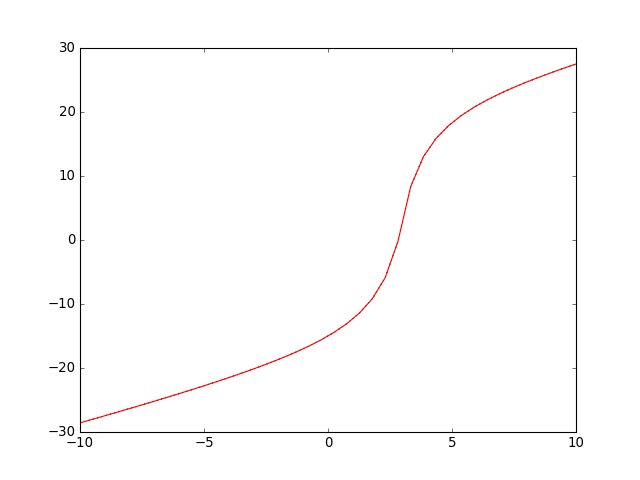

In [13]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [14]:
model

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, alpha_copy_squareplus, beta+alpha_copy_squareplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam]}

In [15]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, deterministic_optimizer_postmap)
scipy_kwargs = postmap(model, wrapper=batch, initial_inputs=[example_target])
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.99995   ,  1.41417821])}

In [16]:
fit = minimize(
    args=(ys,xs),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
); fit

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 25
         Hessian evaluations: 12


     fun: 2.51054983086587e-28
     jac: array([ -3.94380766e-07,   2.01949302e-07,  -2.51502061e-06])
 message: 'Optimization terminated successfully.'
    nfev: 14
    nhev: 12
     nit: 12
    njev: 25
  status: 0
 success: True
       x: array([ 3.        , -0.99995   ,  4.58256478])

Fix fitted parameters into model.

We need to further build a givens dictionary supply the input-info which usually is given when used as theano.function(model['inputs'], model['outputs']).

In [20]:
model['parameters_flat'] = [fit.x]
givens = dict(izip(model['inputs'], [example_target]))

In [ ]:
[(p.name, p.eval(givens)) for p in model['parameters_positive']]

In [ ]:
[(p.name, p.eval(givens)) for p in model['parameters']]

# two dimensions

## model

In [23]:
model2d = dm.RadialTransform()
model2d

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0],
  'parameters_positive': [alpha, beta+alpha]}

In [24]:
model2d.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
model2d

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, alpha_copy_squareplus, beta+alpha_copy_squareplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam]}

## target

In [25]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [28]:
f_target2d = target2d.function()
example_target2d = [7, 4]
f_target2d(example_target2d)  # caution, needs vector not scalar input

array([ 10.33333333,   6.5       ])

In [29]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

array([[-10.        , -10.        ],
       [ -7.77777778, -10.        ],
       [ -5.55555556, -10.        ],
       [ -3.33333333, -10.        ],
       [ -1.11111111, -10.        ]])

In [30]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

array([[-13.60522531, -13.05057526],
       [-11.06368242, -13.35365526],
       [ -8.41972766, -13.68250699],
       [ -5.64595806, -14.01666399],
       [ -2.72417999, -14.31604917]])

## visualization

In [31]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

def plot_fit2d(fig, ax, givens={}, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    f_model2d = model2d.function(givens=givens)
    m_ys2d = np.array([f_model2d(x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    fig.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


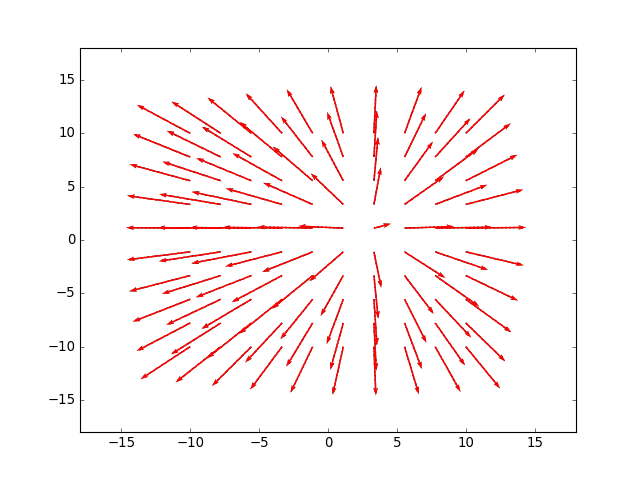

In [32]:
fig, ax = plt.subplots()
plot_fit2d(fig, ax)

## fit

In [33]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, deterministic_optimizer_postmap)
scipy_kwargs2d = postmap(model2d, wrapper=batch, initial_inputs=[example_target2d])
scipy_kwargs2d

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.        ,  0.99995   ,  1.41417821])}

In [34]:
fit = minimize(
    args=(ys2d,xs2d),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit2d(fig, ax, {model2d['parameters_flat'][0]:xs}),
    **scipy_kwargs2d
); fit

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 28
         Hessian evaluations: 13


     fun: 7.070044445578721e-21
     jac: array([ -1.62024842e-04,   4.87423924e-05,   3.46724638e-06,
        -4.52915930e-06])
 message: 'Optimization terminated successfully.'
    nfev: 16
    nhev: 13
     nit: 13
    njev: 28
  status: 0
 success: True
       x: array([ 3.        ,  1.        ,  0.99995   ,  2.44946933])

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [6]:
base_model = pm.DiagGauss(output_size=2)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform()

In [7]:
normalizing_flow(transform_model, base_model)
model = Merge(transform_model, base_model)
model

{ 'inputs': [],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'logP': <FunctionWrapper at 0x7f0022778f30 for function at 0x7f0062b09f50>,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, mean],
  'parameters_positive': [alpha, beta+alpha, var]}

In [8]:
# model.map('parameters_positive',reparameterize_map(squareplus, squareplus_inv), 'parameters')
model.map('parameters_positive',reparameterize_map(softplus, softplus_inv), 'parameters')
model

{ 'inputs': [],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'logP': <FunctionWrapper at 0x7f0022778f30 for function at 0x7f0062b09f50>,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [ z0,
                  mean,
                  alpha_copy_softplus,
                  beta+alpha_copy_softplus,
                  var_copy_softplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam, var_reparam]}

## target

In [9]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [10]:
normalizing_flow(transform_target, base_target)
target = Merge(transform_target, base_target)
t_sampler = target.function()
t_sampler()

array([ 29.35724695,  12.09549545])

In [11]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [12]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


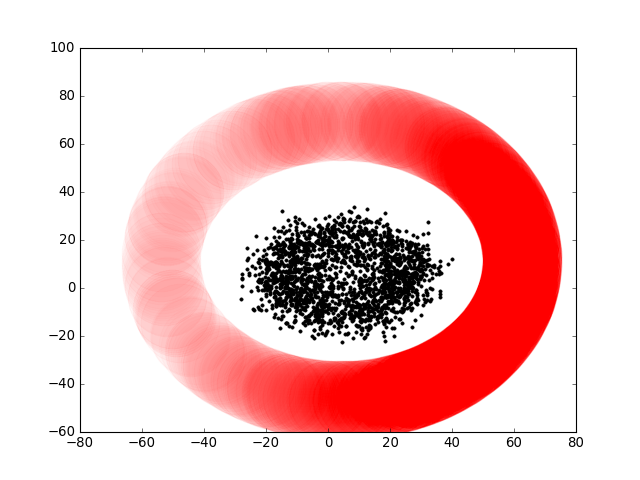

In [13]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [62]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, wrapper=batch, initial_inputs=[])
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.54132485,
         1.85458654,  0.54132485,  0.54132485])}

In [63]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':10000, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}, time_delay=0.001),
    **scipy_kwargs
); fit

         Current function value: 392296.304673
         Iterations: 0
         Function evaluations: 18
         Gradient evaluations: 7


      fun: array(392296.3046725788)
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([  1.93474778e+01,   8.48388103e+00,  -1.01938735e+04,
        -1.04204674e+04,   2.19830740e+04,  -2.88820234e+04,
        -1.48728322e+05,  -9.51017209e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 18
      nit: 0
     njev: 7
   status: 2
  success: False
        x: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.54132485,
        1.85458654,  0.54132485,  0.54132485])

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.

# adding regularizer

In [58]:
postmap_kwargs = {
    'wrapper': compose(chunk, batch),
    'wrapper_kwargs': {
        'chunk_size': 30
    },
    'initial_inputs': [],
    'regularizer_scalar': 0.01,
    #, 'regularizer_norm': L1
}
postmap = compose(scipy_postmap,flat_numericalize_postmap,regularizer_postmap,
                  flatten_parameters,probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, **postmap_kwargs)
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_chunked>,
 'jac': <function schlichtanders.myoptimizers.f_chunked>,
 'x0': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.54132485,
         1.85458654,  0.54132485,  0.54132485])}

In [66]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':10000, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}, time_delay=0.001),
    **scipy_kwargs
); fit

         Current function value: 6404.621344
         Iterations: 21
         Function evaluations: 50
         Gradient evaluations: 39


      fun: 6404.621343583489
 hess_inv: array([[  1.39815622e-03,  -1.64604854e-03,   1.42071708e-03,
         -1.62407587e-03,   2.77213075e-03,  -6.04783384e-03,
          8.57752603e-04,   1.01584922e-03],
       [ -1.64604854e-03,   7.81531367e-02,  -2.84248635e-03,
          7.70602964e-02,  -1.32414298e-01,   3.17566783e-01,
         -4.65211278e-02,  -5.20624432e-02],
       [  1.42071708e-03,  -2.84248635e-03,   1.46363677e-03,
         -2.80155118e-03,   4.90296876e-03,  -1.11484227e-02,
          1.60537769e-03,   1.84672780e-03],
       [ -1.62407587e-03,   7.70602964e-02,  -2.80155118e-03,
          7.59862944e-02,  -1.30466538e-01,   3.12907912e-01,
         -4.58381475e-02,  -5.13034788e-02],
       [  2.77213075e-03,  -1.32414298e-01,   4.90296876e-03,
         -1.30466538e-01,   2.36269669e-01,  -5.65188094e-01,
          8.28026243e-02,   9.21124305e-02],
       [ -6.04783384e-03,   3.17566783e-01,  -1.11484227e-02,
          3.12907912e-01,  -5.65188094e-01,   1.35431

In [67]:
givens = {model['parameters_flat'][0]:fit.x}
print transform_model.beta.eval(givens)
pprint({m.name: m.eval(givens) for m in model['parameters'] + model['parameters_positive']})

58.149283353
{'alpha_copy_softplus_flat': array(-20.839814773149882),
 'alpha_reparam': array(8.899865429524016e-10),
 'beta+alpha_copy_softplus_flat': array(58.14928335384195),
 'beta+alpha_reparam': array(58.14928335384195),
 'mean_flat': array([  4.35655105,  11.40436885]),
 'var_copy_softplus_flat': array([-6.23521083, -5.76631957]),
 'var_reparam': array([ 0.0019573 ,  0.00312637]),
 'z0_flat': array([  4.31070908,  11.42514805])}
